# DS Final Project
# Satvik Reddy Konda
# 26002304774

## INTRODUCTION

This notebook is a development of a prediction modeling pipeline for analyzing NBA shooting performance using situational and spatial data from the 2024-25 NBA season. By moving beyond traditional methods with only using basic basketball statistics, this notebook uses ML methods to understand the hidden meaning behind taken shots, and to classify if shots are made or not made. Furthermore, an additional goal is set which tries to use the models prediction probabilities to compare team/player performances. 

### Goals
1. Build and evaluate two different models. First is a baseline Randmo Forest with the second being a MLP model to predict the likelihood of a shot being made based on its context
2. Feature engineer NBA data into addtional meaningful variables (normalization, categorical simplification)
3. Calculate Expected Points (xPts) and Points Over Expectation (POE) to apply the best model to a real world scenario to show how the model and NBA analytics can be used for understanding player performance

### Pipeline Flow
1. Data Preprocessing: Cleaning, One Hot Encoding, Feature Engineering, Scaling
2. Exploratory Data Analysis: Plotting Various Information 
3. Model Developement: Random Forest, MLP, Grid Search 
4. Model Evaluation: Accuracy, ROC-AUC, Feature Importances
5. Case Study: Using Model Probabilities for a real world player/team performance comparisons

## 1. Imports

1. Data Handling and API: The first group of libraries used for retreiving basketball shots data from the NBA API and conducting data manipulation

2. Data Visualization: Second group for visualizing different components of the data

3. ML Preprocessing and Model Selection: Third group for preperation of data for the inputs of the model

4. Model Algorithm: Fourth group as the imports for the actual model, one for baseline and the other as an advanced model

5. Model Evaluation: Fifth group as the imports for understanding performance and importances

In [4]:
import pandas as pd
import numpy as np
import json
from nba_api.stats.endpoints import shotchartdetail

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance


## 2. Data Creation

### 2.1 Data Retreival for Model Training (2024-25 season)

Block1: API request initialization to retreive every shot attempt from the 2024-25 nba season. player_id and team_id being set to 0 ensures all teams/players data is collected

Block2: Takes the json response and retreives the headers and rows for the dataframe to be created

Block3: Converts the json raw data into a csv and saves it

In [5]:
response = shotchartdetail.ShotChartDetail(
    team_id=0,
    player_id=0,
    season_nullable='2024-25',
    season_type_all_star='Regular Season',
    context_measure_simple='FGA'
)

In [6]:
content = json.loads(response.get_json())
results = content['resultSets'][0]
headers = results['headers']
rows = results['rowSet']

In [7]:
df = pd.DataFrame(rows, columns=headers)
df.to_csv('nba_shot_data_2024_25.csv', index=False)

### 2.2 Data Retreival for Case Study Testing (2025-26 season data so far)

The code below retreives the shot data for the current season of 2025-26 which is still ongoing. While the 2024-25 season data is used for model training, this dataset is for the short case study that will be preformed later (to compare model probabilties to actual player performance for the 2025-26 season)

In [8]:
response2 = shotchartdetail.ShotChartDetail(
    team_id=0,
    player_id=0,
    season_nullable='2025-26',
    season_type_all_star='Regular Season',
    context_measure_simple='FGA'  # FGA ensures we get both Makes and Misses
)

# 2. Parse the JSON response
content2 = json.loads(response2.get_json())
results2 = content2['resultSets'][0]
headers2 = results2['headers']
rows2 = results2['rowSet']

# 3. Create DataFrame and Export to CSV
df2 = pd.DataFrame(rows2, columns=headers2)
df2.to_csv('nba_shot_data_2025_26.csv', index=False)

### 2.3 DataFrame Visualization

The code below is to visually check if the DataFrame was created properly. To prepare for data cleaning and feature engineering, the type and number of columns were checked in addition of checking for any missing data

In [9]:
print(f"Dataset Shape: {df.shape}")
df.head()


Dataset Shape: (219527, 24)


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022400001,7,1642258,Zaccharie Risacher,1610612737,Atlanta Hawks,1,11,43,...,Left Side Center(LC),24+ ft.,26,-168,205,1,0,20241112,BOS,ATL
1,Shot Chart Detail,0022400001,10,1630552,Jalen Johnson,1610612737,Atlanta Hawks,1,11,38,...,Left Side(L),8-16 ft.,13,-136,-1,1,0,20241112,BOS,ATL
2,Shot Chart Detail,0022400001,12,1628401,Derrick White,1610612738,Boston Celtics,1,11,24,...,Left Side Center(LC),24+ ft.,28,-181,218,1,0,20241112,BOS,ATL
3,Shot Chart Detail,0022400001,21,1630552,Jalen Johnson,1610612737,Atlanta Hawks,1,10,50,...,Right Side Center(RC),24+ ft.,25,157,203,1,1,20241112,BOS,ATL
4,Shot Chart Detail,0022400001,23,1627759,Jaylen Brown,1610612738,Boston Celtics,1,10,35,...,Right Side Center(RC),24+ ft.,27,102,253,1,1,20241112,BOS,ATL


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219527 entries, 0 to 219526
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   GRID_TYPE            219527 non-null  object
 1   GAME_ID              219527 non-null  object
 2   GAME_EVENT_ID        219527 non-null  int64 
 3   PLAYER_ID            219527 non-null  int64 
 4   PLAYER_NAME          219527 non-null  object
 5   TEAM_ID              219527 non-null  int64 
 6   TEAM_NAME            219527 non-null  object
 7   PERIOD               219527 non-null  int64 
 8   MINUTES_REMAINING    219527 non-null  int64 
 9   SECONDS_REMAINING    219527 non-null  int64 
 10  EVENT_TYPE           219527 non-null  object
 11  ACTION_TYPE          219527 non-null  object
 12  SHOT_TYPE            219527 non-null  object
 13  SHOT_ZONE_BASIC      219527 non-null  object
 14  SHOT_ZONE_AREA       219527 non-null  object
 15  SHOT_ZONE_RANGE      219527 non-nu

In [11]:
df.isna().sum()

GRID_TYPE              0
GAME_ID                0
GAME_EVENT_ID          0
PLAYER_ID              0
PLAYER_NAME            0
TEAM_ID                0
TEAM_NAME              0
PERIOD                 0
MINUTES_REMAINING      0
SECONDS_REMAINING      0
EVENT_TYPE             0
ACTION_TYPE            0
SHOT_TYPE              0
SHOT_ZONE_BASIC        0
SHOT_ZONE_AREA         0
SHOT_ZONE_RANGE        0
SHOT_DISTANCE          0
LOC_X                  0
LOC_Y                  0
SHOT_ATTEMPTED_FLAG    0
SHOT_MADE_FLAG         0
GAME_DATE              0
HTM                    0
VTM                    0
dtype: int64

## 3. Feature Engineering

Through feature engineering, new columns were created to help the model understand context better. The justification for these decisions are made through domain knowledge with how they are constructed below

1. takes the X and Y coordinates of each shot to find the angle relative to the basket. This allows the model to understand the difference between a corner shot versus a shot straight on. This calculation is done through numpy's arctan2 function

2. Creates a binary value to define a clutch moment, describes as a shot taken in the final 3 mins of the 4th quarter. This specific timeframe allows the model to understand shots that are taken during increased preassure

3. The NBA API has over 50 types of descriptions for describing the type of action taken during a shot. To prevent the model from overfitting, this function collapes those actions types into 6 bigger groups which describe the fundametal shooting types. This was done through lower casing all the letters and grouping each type if they had a specific key word in them

4. These additional features created add more information for the model to understand. TOTAL_SECONDS_LEFT convert the two columns of mins and secs remaining into a single numerical value. DISTANCE_SQUARED allows the model to understand the importance of the distance the shot was taken from. For example, a shot difference between 1 meter and 2 meter is less significant/harder than 5 meters to 6 meters (squaring penalizes the bigger numbers more)

Finally, the new features are visualized to make sure they were created correctly

In [29]:
def engineer_nba_features(df):
    
    # 1. SHOT ANGLE 
    df['SHOT_ANGLE'] = np.arctan2(df['LOC_X'], df['LOC_Y'])

    # 2. CLUTCH SHOT
    df['IS_CLUTCH'] = (
        ((df['PERIOD'] >= 4) & (df['MINUTES_REMAINING'] <= 3)) | 
        (df['PERIOD'] > 4)
    ).astype(int)

    # 3. CONDENSING ACTION TYPES
    def simplify_action(action):
        action = action.lower()
        if 'dunk' in action: return 'Dunk'
        if 'layup' in action: return 'Layup'
        if 'hook' in action: return 'Hook'
        if 'fadeaway' in action: return 'Fadeaway'
        if 'pullup' in action or 'stepback' in action: return 'Off-Dribble'
        if 'jump' in action: return 'Jump-Shot'
        return 'Other'
    
    df['ACTION_GROUP'] = df['ACTION_TYPE'].apply(simplify_action)

    # 4. ADDITIONAL FEATURES
    df['TOTAL_SECONDS_LEFT'] = (df['MINUTES_REMAINING'] * 60) + df['SECONDS_REMAINING']
    df['DISTANCE_SQUARED'] = df['SHOT_DISTANCE'] ** 2

    return df

df = engineer_nba_features(df)

df[['PLAYER_NAME', 'ACTION_GROUP', 'SHOT_ANGLE', 'IS_CLUTCH', 'TOTAL_SECONDS_LEFT']].head()

,PLAYER_NAME,ACTION_GROUP,SHOT_ANGLE,IS_CLUTCH,TOTAL_SECONDS_LEFT
0,Zaccharie Risacher,Jump-Shot,-0.686526,0,703
1,Jalen Johnson,Jump-Shot,-1.578149,0,698
2,Derrick White,Jump-Shot,-0.692931,0,684
3,Jalen Johnson,Jump-Shot,0.658309,0,650
4,Jaylen Brown,Off-Dribble,0.383229,0,635


## 4. Data Cleaning

This step involves removing columns that are irrelevant or are uneeded as the inputs for the model through the usage of .drop() from pandas. For example, all of the ID's and SHOT_ATTEMPTED_FLAG are removed as they do not have value for the prediction process.

MINUTES_REMAINING and SECONDS_REMAINING are also removed as a condensed version was already created before. 

HTM and VTM which represent who was the home team and away team were also removed as predicting if a shot will go in or not does not depend on where the team is playing

Finally, the dataframe was visualized to double check the cleaning process worked. Additionaly, because previous checks revealed that there are no missing data, the data preperation process for the model ends here

In [13]:
cols_to_drop = [
    'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'TEAM_ID',
    'TEAM_NAME', 'EVENT_TYPE', 'MINUTES_REMAINING', 
    'SECONDS_REMAINING', 'GAME_DATE', 'HTM', 'VTM', 'SHOT_ATTEMPTED_FLAG'
]

df_clean = df.drop(columns=cols_to_drop)

print(f"Remaining columns: {list(df_clean.columns)}")
df_clean.head()

Remaining columns: ['PLAYER_NAME', 'PERIOD', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'SHOT_ANGLE', 'IS_CLUTCH', 'ACTION_GROUP', 'TOTAL_SECONDS_LEFT', 'DISTANCE_SQUARED']


,PLAYER_NAME,PERIOD,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,SHOT_ANGLE,IS_CLUTCH,ACTION_GROUP,TOTAL_SECONDS_LEFT,DISTANCE_SQUARED
0,Zaccharie Risacher,1,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-168,205,0,-0.686526,0,Jump-Shot,703,676
1,Jalen Johnson,1,Driving Floating Bank Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,13,-136,-1,0,-1.578149,0,Jump-Shot,698,169
2,Derrick White,1,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28,-181,218,0,-0.692931,0,Jump-Shot,684,784
3,Jalen Johnson,1,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,157,203,1,0.658309,0,Jump-Shot,650,625
4,Jaylen Brown,1,Pullup Jump shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,27,102,253,1,0.383229,0,Off-Dribble,635,729


In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219527 entries, 0 to 219526
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   PLAYER_NAME         219527 non-null  object 
 1   PERIOD              219527 non-null  int64  
 2   ACTION_TYPE         219527 non-null  object 
 3   SHOT_TYPE           219527 non-null  object 
 4   SHOT_ZONE_BASIC     219527 non-null  object 
 5   SHOT_ZONE_AREA      219527 non-null  object 
 6   SHOT_ZONE_RANGE     219527 non-null  object 
 7   SHOT_DISTANCE       219527 non-null  int64  
 8   LOC_X               219527 non-null  int64  
 9   LOC_Y               219527 non-null  int64  
 10  SHOT_MADE_FLAG      219527 non-null  int64  
 11  SHOT_ANGLE          219527 non-null  float64
 12  IS_CLUTCH           219527 non-null  int64  
 13  ACTION_GROUP        219527 non-null  object 
 14  TOTAL_SECONDS_LEFT  219527 non-null  int64  
 15  DISTANCE_SQUARED    219527 non-nul

## 5. Exploratory Data Analysis (EDA)

### 5.1 Map of Shots Taken

The code below creates a map of every shot taken. Using the LOC_X and LOC_Y variables, it creates a map to check where shots have been taken from. 5000 data points were randomly sampled so that the plot does not become overcrowded. In addition, they were color coded to understand what shots have been missed or made. With (0,0) being where the basket is located, for example, we can see that more shots were made (blue) than not (red) near the basket. 

This plot gives us the understanding that there is a relationship between the "location of the shot" versus "if it went in or not" that needs to be explored. 

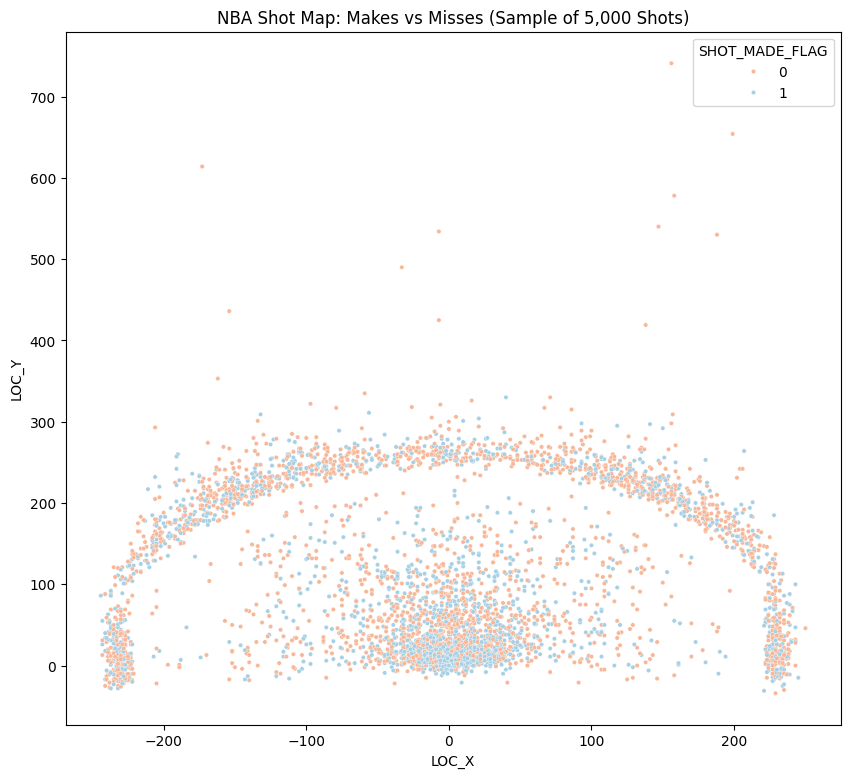

In [15]:
plt.figure(figsize=(10, 9))
sns.scatterplot(data=df.sample(5000), x='LOC_X', y='LOC_Y', hue='SHOT_MADE_FLAG', palette='RdBu', alpha=1, s=10)
plt.title('NBA Shot Map: Makes vs Misses (Sample of 5,000 Shots)')
plt.show()

### 5.2 Team Efficiency Leaders by Zone

1. This set of code uses the grouby function to organize the data by team and shot location. This is then used to calculate the field goal percentage (mean) while filtering it through the number of shots a team has taken (count). The filter is set at count > 100 to make sure that the leaders of each zone are based on a big sample size and not an outlier with a high field goal percentage

2. The loop goes through each area on the court as well as the filtered data and sorts them by their shot success rate in descending order (ascending = False). Then the iloc[0] selects the best preforming team for the given zone which is then stored in the list called leaders_list.

3. This line of code takes the dictionary of leader_list and converts it into a dataframe. As matplotlib and seaborn can handle dataframes directly, this step was conducted.

4. This creates the plot where the x labels are created by combining the zone name with the team name. 

5. The final step iterates through each of the x axis labels and places the percentage on top of the bar. It ends with labeling other parts of the plot and displaying it

This plot acts as the baseline. Before building a model and using it to predict shot make percentages, this plot creates a baseline understanding of who's the best at what type of shot, which helps future comparisons.

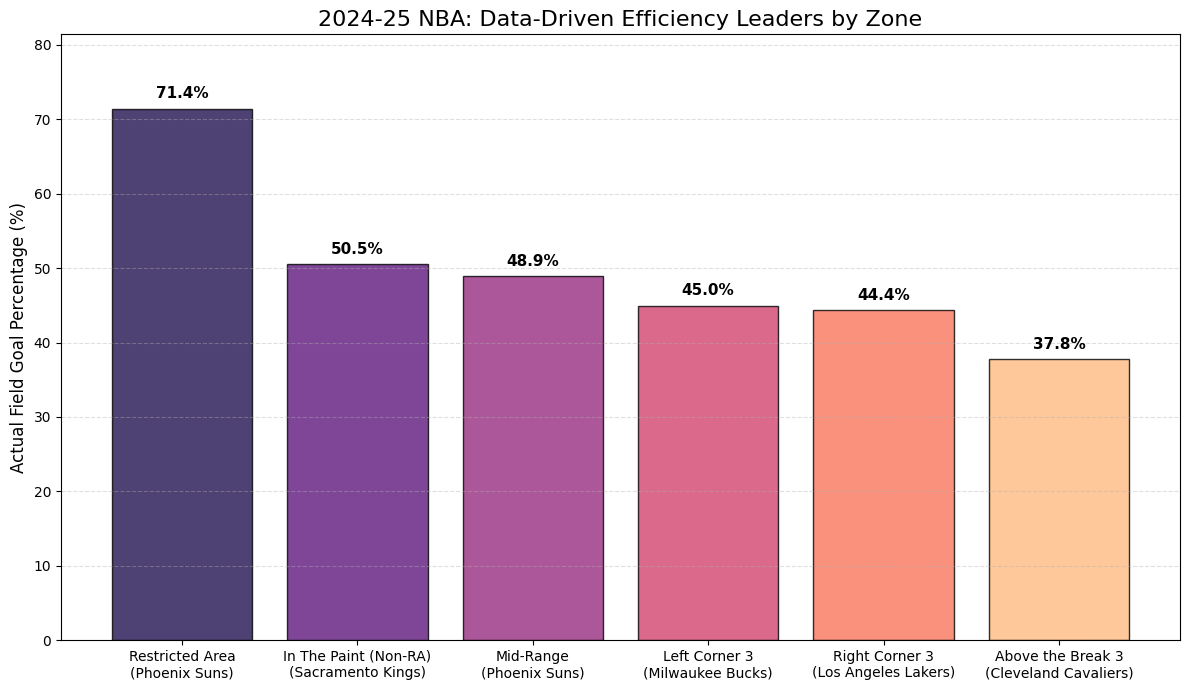

In [16]:
# 1. Calculating leaders from data
zone_stats = df.groupby(['SHOT_ZONE_BASIC', 'TEAM_NAME'])['SHOT_MADE_FLAG'].agg(['mean', 'count']).reset_index()
significant_zones = zone_stats[zone_stats['count'] > 100]

# 2. Identifying top team for each zone
target_zones = [
    'Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range', 
    'Left Corner 3', 'Right Corner 3', 'Above the Break 3'
]

leaders_list = []
for zone in target_zones:
    top_team = significant_zones[significant_zones['SHOT_ZONE_BASIC'] == zone].sort_values(by='mean', ascending=False).iloc[0]
    leaders_list.append({
        'Zone': zone,
        'Team': top_team['TEAM_NAME'],
        'FG%': top_team['mean'] * 100
    })

# 3. Createdf from the results
plot_df = pd.DataFrame(leaders_list)

# 4. Plotting
plt.figure(figsize=(12, 7))
colors = sns.color_palette("magma", len(plot_df))
bars = plt.bar(plot_df['Zone'] + "\n(" + plot_df['Team'] + ")", plot_df['FG%'], color=colors, edgecolor='black', alpha=0.8)

# 5. labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title('2024-25 NBA: Data-Driven Efficiency Leaders by Zone', fontsize=16)
plt.ylabel('Actual Field Goal Percentage (%)', fontsize=12)
plt.ylim(0, max(plot_df['FG%']) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

### 5.3 Shot Type Efficiency

The groupby method clusters the data by the type of shot based on if it has been made or not. Through this, the mean is found to calculate the probability that a specific type of shot will go in or not (also sorting through desending order)

This plot was created to justify the aggregation of the 50+ shot types as a new category. As the plot shows, there are fairly large margins between shot types which the model can understand to predict shot outcomes and its probabilties

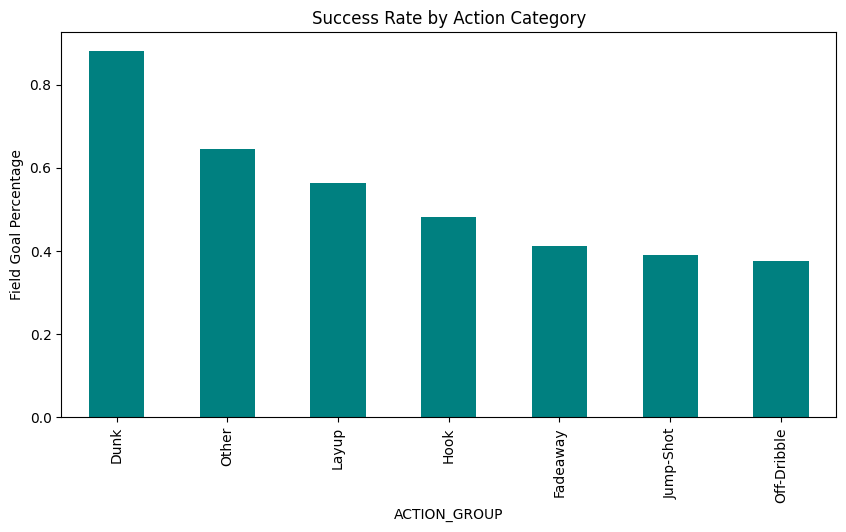

In [17]:
action_eff = df.groupby('ACTION_GROUP')['SHOT_MADE_FLAG'].mean().sort_values(ascending=False)
action_eff.plot(kind='bar', color='teal', figsize=(10, 5))
plt.ylabel('Field Goal Percentage')
plt.title('Success Rate by Action Category')
plt.show()

### 5.4 Correlation Analysis

1. This line uses the .corr() method to find the linear relationship between the target varible (SHOT_MADE_FLAG) to all of the other numeric variables in the data. numeric_only=True makes sure that categorical variables are ignored where sort_values orders the correlation value from strongest positive to strongest negative

2. This line is soely to make the plot cleaner where SHOT_MADE_FLAG is not compared to itself with an obvious correlation value of 1

3. The correlation values are then put onto a heatmap through seaborn to visually understand the strength of relationships between variables. vmin and vmax set the bounds for the range of colors than can appear on the heatmap. annot=True makes sure that the actual values are printed as well. 

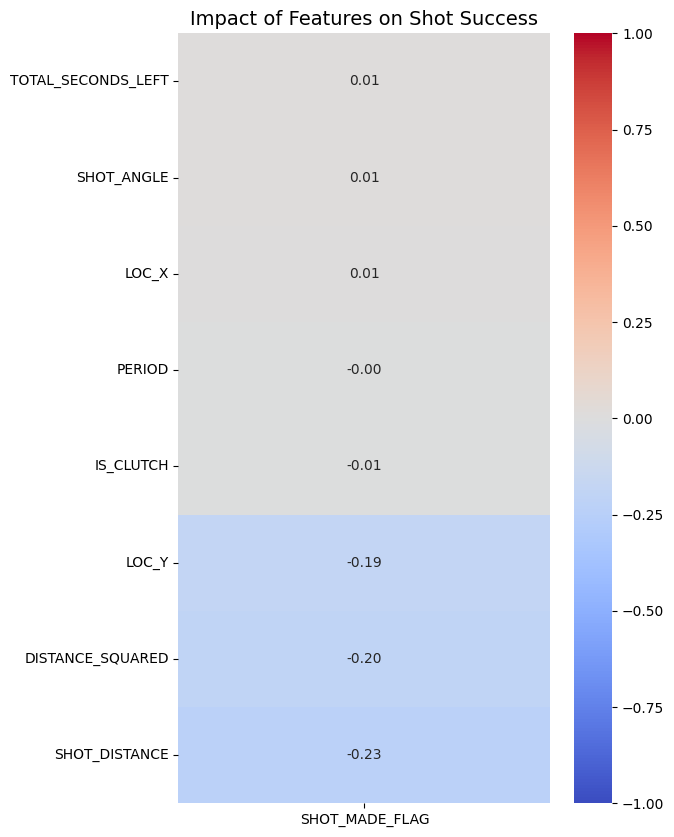

In [18]:
# 1. Calculate correlation for numeric columns
corr_ranking = df_clean.corr(numeric_only=True)[['SHOT_MADE_FLAG']].sort_values(by='SHOT_MADE_FLAG', ascending=False)

# 2. Remove self-correlation
corr_ranking = corr_ranking.drop(index='SHOT_MADE_FLAG')

# 3. Plot
plt.figure(figsize=(6, 10))
sns.heatmap(corr_ranking, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

plt.title('Impact of Features on Shot Success', fontsize=14)
plt.show()

## 6. Predictive Modeling

### 6.1 Feature Construction and Ecoding

1. model_cols defines the specific subset of features that will be used to train the model. These selected features allow the model to capture the full context of each shot taken

2. the .get_dummies() method takes any categorical data represented as text into numbers, with each specific text represented by a number. The dataset involved 5 categorical data and this process encodes in a manner that the model can understand. This is then assigned to the X (input) variable for the model where are numeric columns stay the same and categorical get one hot encoded

3. This line assigns what we are asking the model to predict. During training, the model will use the column of binary values representing a made/missed shot to understand the relationships between the varibles

Finally visualization of the feature matrix and count of mades versus misses is visualized to understand exactly what the model will be given

In [19]:
# 1. Defining Input Features
model_cols = [
    'PERIOD', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 
    'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 
    'SHOT_ANGLE', 'IS_CLUTCH', 'ACTION_GROUP', 
    'TOTAL_SECONDS_LEFT', 'DISTANCE_SQUARED'
]

# 2. One-Hot Encoding
X = pd.get_dummies(df[model_cols], columns=['SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'ACTION_GROUP'])

# 3. Defining Target
y = df['SHOT_MADE_FLAG']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable counts:\n{y.value_counts()}")

Feature matrix shape: (219527, 35)
Target variable counts:
SHOT_MADE_FLAG
0    116961
1    102566
Name: count, dtype: int64


### 6.2 Data splitting 

1. The train_test_split function splits the dataset into two groups. with a train test split of 80/20 with a specific random state set. The X and y variables are the ones created in the previous block with the one hot ecoded/numeric variables and the target variable

2. StandardScaler() was used to standardize all of the numeric values on the same scale. With many columns having different scales such as inches, seconds, x/y coordinates etc., standard scaler sets all of them to mean 0 and standard deviation 1 so that the model can equally evaluate each variable

In [20]:
# 1. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train_scaled.shape[0]} shots")
print(f"Test set size: {X_test_scaled.shape[0]} shots")

Training set size: 175621 shots
Test set size: 43906 shots


### 6.3 Random Forest

1. This dictionary describes the hyperparameter search space that will be tested. Instead of using a fixed model initialized with one set of parameters, specifiying a range of options for the model to try out will allow it to find the most optimal set of hyperparameters. n_estimators describes the number of trees that the model will create to learn the data, max_depth describes the maximum depth of each tree, and min_samples_split describes the minimum number of samples requires for a tree to split into two. 

2. Here the random forest model is initialized with a specific random state where n_jobs=-1 tells the model to use all available CPU cores. Then, the grid search is initialized with GridSearchCV() with the search space defined along side a 3 fold cross validation (18 permutations x 3 fold cross validation = 54 models tested). This grid search model is then used against the data through fit() to find the best hyperparameters which is then saved to best_rf

3. To prove and visualize the accuracy of those parameters, a 5 fold cross validation is done. 

3.1 
The data is split in 5 equal parts with shuffle=True which makes sure that the data is mixed up

3.2 
A loop that runs 5 times. In each loop the model sets up the cross validation data for both X and y and tries to fit the model onto the data 5 times (each time one part is used for validation)

3.3 
predict() makes the model predict if a shot will go in or not where as predict_proba() asks the model to give the probability of the shot being made (the layer right before classification). These probabilties are essential the real domain of basketball for team analysts to analyze players or teams. The model prediction accuracy of a shot going in or not is validation that the given probabilities are accurate. 

3.4 
Then metrics to understand the model performance are calculated. accuracy_score() finds how many times the model predicted a shot going in correctly where as roc_auc_score() describes how well the model was able to separate the positive (made) and negative (miss) classes. 

3.5 
Here, the roc_curve() method find a line of the tradeoff between true positives and false positives for each fold and it then plotted. The further the line is the upper right corner, the better the model

4. This plot is an addition to 3.5 where the diagonal line, title, and legend are created to fully visualize the ROC plot

5. The random forest model keeps track of which variables were important in splitting the data accurately to acheive performance. Through .feature_importance_, the variables are automatically extracted, put into a dataframe, and plotted as a bar graph to visualize.

Searching for optimal Random Forest parameters...

--- 5-FOLD CROSS-VALIDATION RESULTS ---
Fold 1: Accuracy = 0.6265 | ROC-AUC = 0.6539
Fold 2: Accuracy = 0.6324 | ROC-AUC = 0.6581
Fold 3: Accuracy = 0.6276 | ROC-AUC = 0.6527
Fold 4: Accuracy = 0.6264 | ROC-AUC = 0.6509
Fold 5: Accuracy = 0.6256 | ROC-AUC = 0.6555
------------------------------
AVERAGE ACCURACY: 0.6277 (+/- 0.0024)
AVERAGE ROC-AUC:  0.6542 (+/- 0.0025)
------------------------------


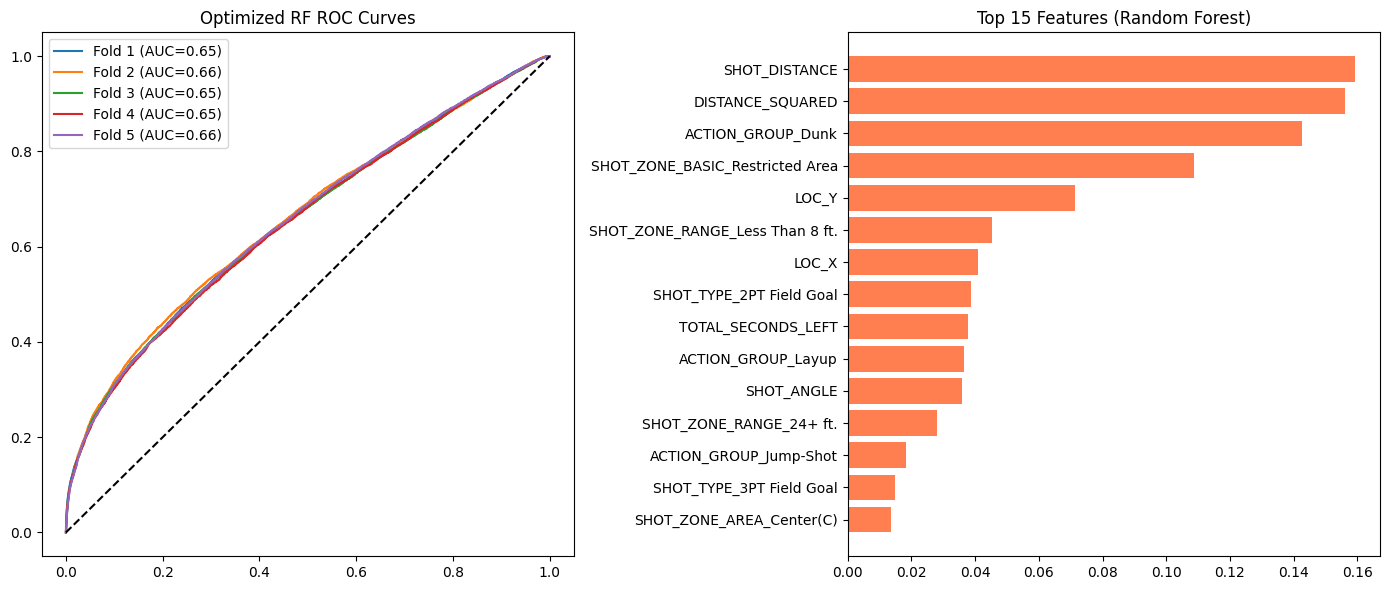

In [21]:
# 1. Define the Random Forest Search Space
rf_param_space = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# 2. Run Randomized Search
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
print("Searching for optimal Random Forest parameters...")
rf_search = GridSearchCV(estimator=rf_base, param_grid=rf_param_space, cv=3, scoring='accuracy', n_jobs=-1)
rf_search.fit(X_train_scaled, y_train)
best_rf = rf_search.best_estimator_

# 3. 5-Fold Cross-Validation

# 3.1 Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_aucs = []

plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 2, 1)

print("\n--- 5-FOLD CROSS-VALIDATION RESULTS ---")

# 3.2 Run 5-Fold Cross-Validation
for i, (t_idx, v_idx) in enumerate(kf.split(X_train_scaled)):
    X_f_t, X_f_v = X_train_scaled[t_idx], X_train_scaled[v_idx]
    y_f_t, y_f_v = y_train.iloc[t_idx], y_train.iloc[v_idx]
    
    best_rf.fit(X_f_t, y_f_t)
    
    # 3.3 Get Predictions and Probabilties
    y_pred = best_rf.predict(X_f_v)
    y_prob = best_rf.predict_proba(X_f_v)[:, 1]
    
    # 3.4 Metrics
    acc = accuracy_score(y_f_v, y_pred)
    f_auc = roc_auc_score(y_f_v, y_prob)
    
    fold_accuracies.append(acc)
    fold_aucs.append(f_auc)
    
    print(f"Fold {i+1}: Accuracy = {acc:.4f} | ROC-AUC = {f_auc:.4f}")
    
    # 3.5 ROC Plot
    fpr, tpr, _ = roc_curve(y_f_v, y_prob)
    ax1.plot(fpr, tpr, label=f'Fold {i+1} (AUC={f_auc:.2f})')

print("-" * 30)
print(f"AVERAGE ACCURACY: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print(f"AVERAGE ROC-AUC:  {np.mean(fold_aucs):.4f} (+/- {np.std(fold_aucs):.4f})")
print("-" * 30)

# 4. ROC Plot
ax1.plot([0,1],[0,1], 'k--')
ax1.set_title('Optimized RF ROC Curves')
ax1.legend()

# 5. Feature Importance Plot
importances = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=False).head(15)
ax2 = plt.subplot(1, 2, 2)
ax2.barh(rf_importance_df['feature'], rf_importance_df['importance'], color='coral')
ax2.set_title('Top 15 Features (Random Forest)')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### 6.4 MLP

On top of the baseline model, an MLP model was also trained as an advanced model that could extract better performance. In terms of the code, the setup is exactly the same as the random forest (see 6.3 for more info) with exception to some MLP specific setups

1. Once again, instead of setting up the MLP model with one set of hyperparameters, a set of them were chosen to be run through GridSearchCV() to get the best possible values. hidden_layer_sizes describes the architecture where both number of layers and neurons are described. alpha describes the penalty the model will gives for complex node weights (keeps the model simple). learning_rate_init describes how big of a step the model will take to find the optimal weight. the chosen activation functions are relu and tanh where they turn off neurons that are not helpful and build smoother more complex curves respectively. 

2. This set of code initializes the MLP model and finds the optimal hyperparameters. With it being initialized through MLPClassifer(), max_iter=500 describes how many passes the model will make through the data where as early_stopping=True means that if performance improvements are minimal, then it will stop training. Finally, just like random forest, the model is run through GridSearchCV() to test the hyperparameters and finds the best of them (see 6.3 for more details about this method)

3. Unlike random forests, neural networks such as MLP do not have a way to show which features contributed to the performance the most. Therefore from sklearn.inspection, permutation_importance() is used. It takes one variable at a time, shuffles the column randomly and checks if the model performance drops. If yes then it means that the specific variable was vital for performance. Running through all of the variables, the plot ranks them in terms of how much the performance dropped (in other words how important it was)

Once again, the ROC curve is plotted (see 6.3 for details about this plot)

Searching for optimal Neural Network parameters...
Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}

--- 5-FOLD CROSS-VALIDATION RESULTS (MLP) ---
Fold 1: Accuracy = 0.6253 | ROC-AUC = 0.6492
Fold 2: Accuracy = 0.6319 | ROC-AUC = 0.6551
Fold 3: Accuracy = 0.6275 | ROC-AUC = 0.6506
Fold 4: Accuracy = 0.6237 | ROC-AUC = 0.6485
Fold 5: Accuracy = 0.6256 | ROC-AUC = 0.6511
-----------------------------------
AVERAGE ACCURACY: 0.6268 (+/- 0.0028)
AVERAGE ROC-AUC:  0.6509 (+/- 0.0023)
-----------------------------------

Calculating Feature Importance for MLP...


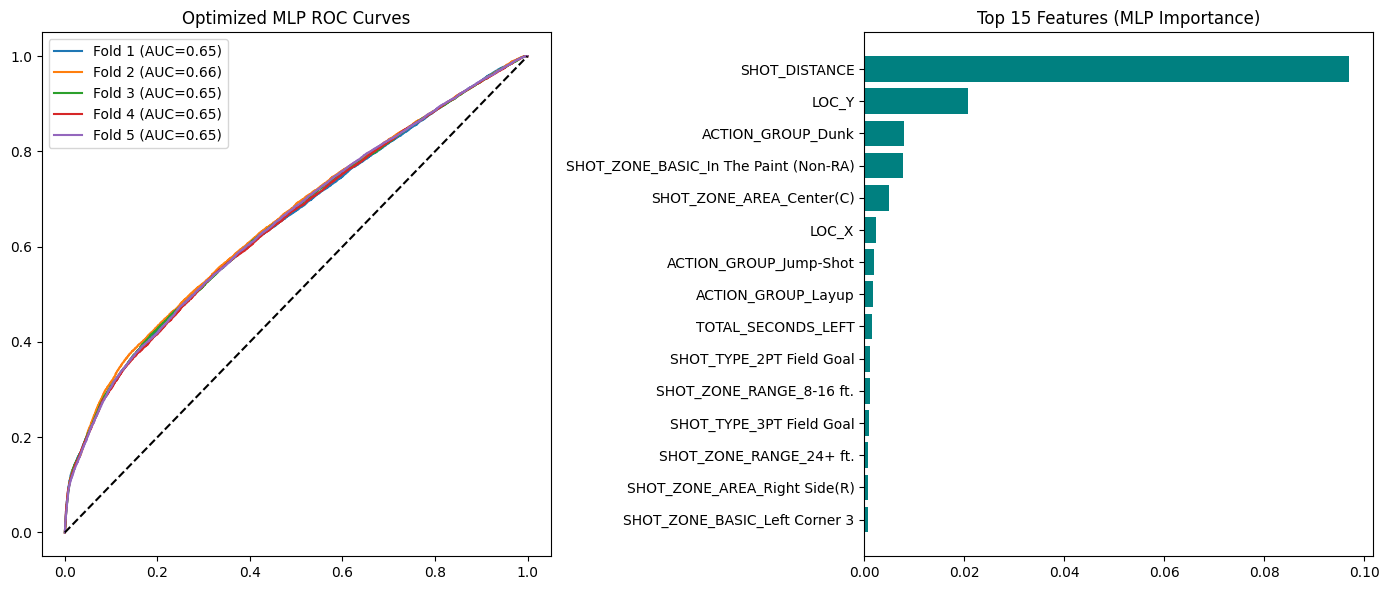

In [23]:
# 1. Search Space
param_space = {
    'hidden_layer_sizes': [(64,), (128, 64), (64, 32, 16), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu', 'tanh']
}

# 2. Initialize and Run Randomized Search
mlp_base = MLPClassifier(max_iter=500, early_stopping=True, random_state=42)
print("Searching for optimal Neural Network parameters...")
search = GridSearchCV(estimator=mlp_base, param_grid=param_space, cv=3, scoring='accuracy', n_jobs=-1)
search.fit(X_train_scaled, y_train)
best_mlp = search.best_estimator_
print(f"Best Parameters: {search.best_params_}")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_aucs = []

plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 2, 1)

print("\n--- 5-FOLD CROSS-VALIDATION RESULTS (MLP) ---")
for i, (t_idx, v_idx) in enumerate(kf.split(X_train_scaled)):
    X_f_t, X_f_v = X_train_scaled[t_idx], X_train_scaled[v_idx]
    y_f_t, y_f_v = y_train.iloc[t_idx], y_train.iloc[v_idx]
    
    best_mlp.fit(X_f_t, y_f_t)
    
    y_pred = best_mlp.predict(X_f_v)
    y_prob = best_mlp.predict_proba(X_f_v)[:, 1]
    
    acc = accuracy_score(y_f_v, y_pred)
    f_auc = roc_auc_score(y_f_v, y_prob)
    
    fold_accuracies.append(acc)
    fold_aucs.append(f_auc)
    
    print(f"Fold {i+1}: Accuracy = {acc:.4f} | ROC-AUC = {f_auc:.4f}")
    
    fpr, tpr, _ = roc_curve(y_f_v, y_prob)
    ax1.plot(fpr, tpr, label=f'Fold {i+1} (AUC={f_auc:.2f})')

print("-" * 35)
print(f"AVERAGE ACCURACY: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print(f"AVERAGE ROC-AUC:  {np.mean(fold_aucs):.4f} (+/- {np.std(fold_aucs):.4f})")
print("-" * 35)

ax1.plot([0,1],[0,1], 'k--')
ax1.set_title('Optimized MLP ROC Curves')
ax1.legend()

# 3. Feature Importance Calculation (Permutation)
print("\nCalculating Feature Importance for MLP...")
r = permutation_importance(best_mlp, X_test_scaled[:5000], y_test.iloc[:5000],
                           n_repeats=10, random_state=42, scoring='accuracy')

importance_df = pd.DataFrame({'feature': X.columns, 'importance': r.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(15)

ax2 = plt.subplot(1, 2, 2)
ax2.barh(importance_df['feature'], importance_df['importance'], color='teal')
ax2.set_title('Top 15 Features (MLP Importance)')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Case Study: Evaluating Miami Heat's Shot Efficiency

While the models have been trained with the performance analyzed, is it also important to understand why the model had to be trained and its real world application. This short case study goes beyond model training and mimicks real life basketball analysts by utilizing the trained MLP model to analyze a the Miami Heat's shot efficiency in comparison to the league averages calculated by the model. 

The data used for the model is for the current NBA season (2025-26) where two things are calculated
1. Expected Points (xPts): measure the quality of the shot the team/player takes (regardless or making it or not)
2. Points Over Expectation (POE): how much scoring value a team/player gives compared to the average

### 7.1 Team Efficiency Analysis

1. Taking the 2025-26 data retreived from before, it is filtered for the Miami Heat. Then the features are transformed using the StandardScaler as inputs into the model (check 6.2 for reasoning behind StandardScaler)

2. The Heat's data is passed through the MLP that was trained on the 2024-25 season previously (done through predict_proba()). This function caculates the likelihood of each shot being a make. This acts as a expected shot made percentage for all the shot attempts taken

3. This is where the value of the shot is defined. By multiplying the probability of the shot going in and the shot takens value (2 or 3 points), it returns Expected Points (xPts). This describes how many points a average player would produce for that specific scenario. It is considered as the average player because the MLP model was trained on all players/teams which gives probabilities of each shot type for example, based on all data points. (e.g. 3 point shot x 0.43 probability = 1.29 xPts)

4. Given that Miami Heat is being analyzed, the data is collapsed into each player. The sum of actual points versus the xPts is calculated where the expected shot make percentage is averaged.

5. This is where POE is caculated. It shows the point totals a player adds (or does not) to the teams scoring ability compared to the average player. It is calculated by subtracting the total xPts from the total points actually scored by the player. (e.g. 3 point shot made - 1.29 xPts = 1.71 POE and so on)

6. Initializing the scatter plot that will allow for the analysis of heat players compared to the league average

    6.1 Draws the 45 degree line that describes the league average. Player above it and below mean preforming better than average and performing worse than average respectively

    6.2 Iterates through the players and puts their name next to the point on the scatter plot. The +005 ensures that names do not overalap too much

7. After all of the calculation, a table is displayed that ranks the players based on their POE. 

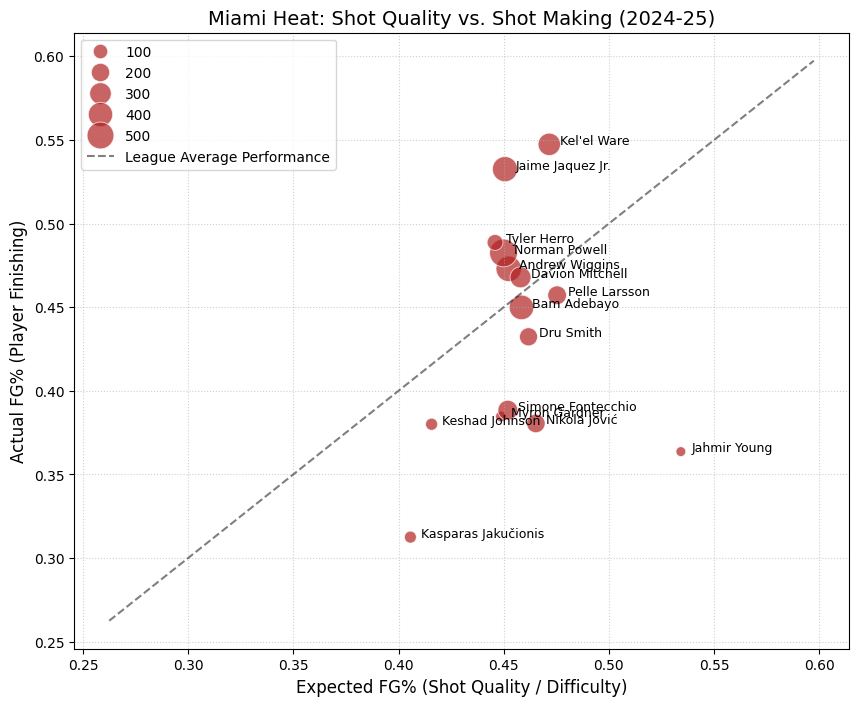


MIAMI HEAT: POINTS OVER EXPECTATION (POE) RANKINGS
             Player  Attempts  Expected_FG%  Actual_FG%     POE
   Jaime Jaquez Jr.       430         0.451       0.533  58.758
        Kel'el Ware       327         0.472       0.547  44.901
      Norman Powell       541         0.450       0.482  26.365
     Andrew Wiggins       444         0.452       0.473  12.167
        Tyler Herro       133         0.446       0.489   5.466
    Davion Mitchell       280         0.458       0.468  -3.141
       Jahmir Young        11         0.534       0.364  -4.295
      Myron Gardner        26         0.449       0.385  -5.530
     Keshad Johnson        50         0.416       0.380  -7.177
Kasparas Jakučionis        48         0.406       0.312  -7.932
      Pelle Larsson       210         0.475       0.457 -19.865
          Dru Smith       192         0.462       0.432 -20.100
        Bam Adebayo       409         0.458       0.450 -24.164
  Simone Fontecchio       242         0.452       0.

In [ ]:
# 1. 2025-26 Data Retreival of Miami Heat
heat_indices = df2[df2['TEAM_NAME'] == 'Miami Heat'].index
X_heat_scaled = scaler.transform(X.loc[heat_indices])

# 2. Extract probabilities from MLP
heat_data = df2.loc[heat_indices].copy()
heat_data['xFG_prob'] = best_mlp.predict_proba(X_heat_scaled)[:, 1]

# 3. Calculate xPts and POE
heat_data['shot_value'] = heat_data['SHOT_TYPE'].apply(lambda x: 3 if '3PT' in x else 2)
heat_data['xPts'] = heat_data['xFG_prob'] * heat_data['shot_value']
heat_data['actual_pts'] = heat_data['SHOT_MADE_FLAG'] * heat_data['shot_value']

# 4. Group by Player
heat_analysis = heat_data.groupby('PLAYER_NAME').agg({
    'SHOT_MADE_FLAG': ['count', 'mean'],
    'xFG_prob': 'mean',
    'actual_pts': 'sum',
    'xPts': 'sum'
}).reset_index()

# 5. Clean up 
heat_analysis.columns = ['Player', 'Attempts', 'Actual_FG%', 'Expected_FG%', 'Total_Pts', 'Expected_Pts']
heat_analysis['POE'] = heat_analysis['Total_Pts'] - heat_analysis['Expected_Pts']

# 6. plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=heat_analysis, x='Expected_FG%', y='Actual_FG%', size='Attempts', sizes=(50, 400), alpha=0.7, color='firebrick')

# 6.1 45 degree line
max_val = max(heat_analysis['Actual_FG%'].max(), heat_analysis['Expected_FG%'].max()) + 0.05
min_val = min(heat_analysis['Actual_FG%'].min(), heat_analysis['Expected_FG%'].min()) - 0.05
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='League Average Performance')

# 6.2 Player Annotation
for i in range(heat_analysis.shape[0]):
    plt.text(heat_analysis['Expected_FG%'][i]+0.005, heat_analysis['Actual_FG%'][i], heat_analysis['Player'][i], fontsize=9)

plt.title('Miami Heat: Shot Quality vs. Shot Making (2024-25)', fontsize=14)
plt.xlabel('Expected FG% (Shot Quality / Difficulty)', fontsize=12)
plt.ylabel('Actual FG% (Player Finishing)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 7. NEW: Final POE Summary Table
print("\n" + "="*60)
print("MIAMI HEAT: POINTS OVER EXPECTATION (POE) RANKINGS")
print("="*60)
summary = heat_analysis[['Player', 'Attempts', 'Expected_FG%', 'Actual_FG%', 'POE']].copy()
summary = summary.sort_values(by='POE', ascending=False)
print(summary.to_string(index=False, float_format=lambda x: "{:.3f}".format(x)))
print("="*60)

### 7.2 Player Efficiency Analysis

The analysis can be taken further by analyzing a specific player for both shot location and type in comparison to the league averages

1. Filtering all shots taken by a player named Jaime Jaquez Jr. through the 2025-26 season so far

2. This groups Jaime's shots by area. Compares his actual shot make percentage (calculated manually from the data) against the expected shot make percentage (calcualted through the probabilities of the MLP model)

3. similar to 2, this groups his shots by the type of shot and still compares the same two things. 

4. sets up the plot (for 2) for visualization of the comparisons. 4.1 plots the shot location comparison and 4.2 plots the shot type comparison. More specifically the melt() function changes the format of the data from pivoting the table. As seaborn cannot directly deal with values that are in different collumns, melt() ensures that its transformed in a way where all the values are on the same column. 

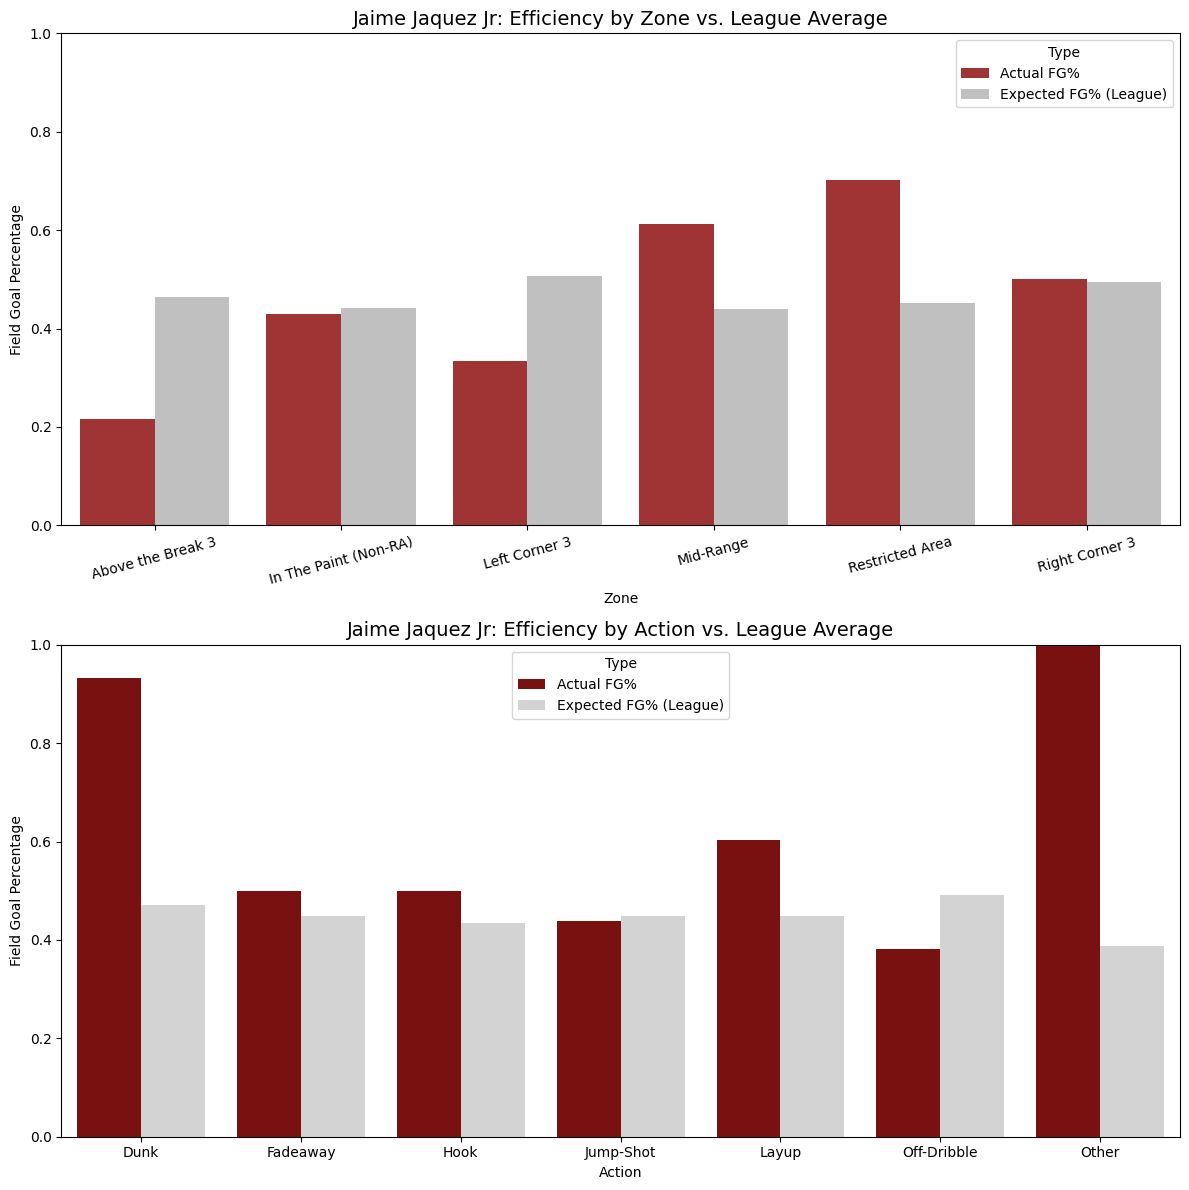

In [35]:
# 1. Prepare Jaime's data and the League baseline
def simplify_action(action):
    action = action.lower()
    if 'dunk' in action: return 'Dunk'
    if 'layup' in action: return 'Layup'
    if 'hook' in action: return 'Hook'
    if 'fadeaway' in action: return 'Fadeaway'
    if 'pullup' in action or 'stepback' in action: return 'Off-Dribble'
    if 'jump' in action: return 'Jump-Shot'
    return 'Other'

if 'ACTION_GROUP' not in heat_data.columns:
    heat_data['ACTION_GROUP'] = heat_data['ACTION_TYPE'].apply(simplify_action)

jaime_full_data = heat_data[heat_data['PLAYER_NAME'] == 'Jaime Jaquez Jr.'].copy()

# 2. Aggregation 1: SHOT_ZONE_BASIC
zone_comp = jaime_full_data.groupby('SHOT_ZONE_BASIC').agg({
    'SHOT_MADE_FLAG': 'mean',
    'xFG_prob': 'mean'
}).reset_index()
zone_comp.columns = ['Zone', 'Actual FG%', 'Expected FG% (League)']

# 3. Aggregation 2: ACTION_GROUP
action_comp = jaime_full_data.groupby('ACTION_GROUP').agg({
    'SHOT_MADE_FLAG': 'mean',
    'xFG_prob': 'mean'
}).reset_index()
action_comp.columns = ['Action', 'Actual FG%', 'Expected FG% (League)']

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 4.1 Plot 1: Shot Zone 
zone_melted = zone_comp.melt(id_vars='Zone', var_name='Type', value_name='Percentage')
sns.barplot(data=zone_melted, x='Zone', y='Percentage', hue='Type', ax=ax1, palette=['firebrick', 'silver'])
ax1.set_title('Jaime Jaquez Jr: Efficiency by Zone vs. League Average', fontsize=14)
ax1.set_ylim(0, 1)
ax1.set_ylabel('Field Goal Percentage')
ax1.tick_params(axis='x', rotation=15)

# 4.2 Plot 2: Action Group
action_melted = action_comp.melt(id_vars='Action', var_name='Type', value_name='Percentage')
sns.barplot(data=action_melted, x='Action', y='Percentage', hue='Type', ax=ax2, palette=['darkred', 'lightgrey'])
ax2.set_title('Jaime Jaquez Jr: Efficiency by Action vs. League Average', fontsize=14)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Field Goal Percentage')

plt.tight_layout()
plt.show()